# Integrating Model-Based and Model-Free Approaches: Dyna-Q 

In this notebook, we investigate a slight modification to the Q-learning algorithm part of the family of "Dyna" Algorithms known as Dyna-Q. In Dyna-Q, we maintain a model that approximates the nature of the MDP by storing previous interactions with the environment. 

Then, for every interaction with the environment we simulate K different interactions with the MDP. We use these simulated experiences to update our q function. 

In [3]:
import gym 
import numpy as np 
import time
import random

### Environment: OpenAI Taxi-v3

For the purposes of this assignment (as in the previous notebook), we use Taxi-v3 from OpenAI's Gym repository. This environment, its states, actions and goals are detailed on the following web page: https://www.gymlibrary.dev/environments/toy_text/taxi/. The environment is kept the same as the vanilla monte-carlo algorithm to be able to compare efficiency and speed.  

In [4]:
env = gym.make("Taxi-v3", render_mode = "human")
env.reset()
env.render()

In [5]:
state_space = env.observation_space
action_space = env.action_space

print("We have {} action space and {} state space".format(action_space, state_space))

We have Discrete(6) action space and Discrete(500) state space


In [4]:
#This function returns an array of action probabilities for a given state (a polic) 
#this policy is designed to be epsilon-greedy in relation to the state action value function Q 
def policy_fn(Q, num_actions, e, state):
    action_probabilities = np.ones(num_actions) * (e/num_actions)
    highest_action_value = np.argmax(Q[state])
    action_probabilities[highest_action_value] += (1 - e)
    
    return action_probabilities

def update_params(Q, state, action, reward, s_next, alpha, gamma) -> None: 
    old_val = Q[state, action]
    #the following step is the difference between Q-learning and SARSA 
    #instead of updating based on the action the policy would pick, we 
    #update based on the best action value possible 
    a_next = np.max(Q[s_next])
    new_val = old_val + alpha * (reward + gamma * a_next - old_val)
    Q[state, action] = new_val

In [6]:
def train_dynaq(num_episodes, e, gamma, alpha, k):
    
    #Initializations 
    Q = np.zeros((state_space.n, action_space.n))
    
    model = [[()]*action_space.n for i in range(state_space.n)]
    states_visited = []
    actions_at_states = [[] for i in range(state_space.n)]
    
    pi = np.zeros((state_space.n, action_space.n))
    epochs_per_episode = []
    
    for i in range(num_episodes):
        
        state = env.reset()
        
        cumulative_reward = 0 
        epoch = 0
        terminated = False 
        print("Episode: {} Epoch: {}".format(i, epoch))
        
        while not terminated: 
            
            states_visited.append(state)
            
            epoch+=1
            if type(state)==tuple: 
                state = state[0]
            
            pi[state] = policy_fn(Q, action_space.n, e, state)
            action = np.random.choice(np.arange(action_space.n), p = pi[state])
            
            actions_at_states[state].append(action)
            
            next_state, reward, terminated, truncated, step_dict = env.step(action)
            
            update_params(Q, state, action, reward, next_state, alpha, gamma)
            model[state][action] = (reward, next_state)
            cumulative_reward+= reward
            
            for i in range(k): 
                state_rand = random.choice(states_visited)
                action_rand = random.choice(actions_at_states[state_rand])
                reward_rand, next_state_rand = model[state_rand][action_rand]
            
            if terminated: 
                print("Episode: {} Epoch: {}".format(i, epoch))
                epochs_per_episode.append(epoch)
            
            state = next_state

Episode: 0 Epoch: 0


/home/aryaman.pandya/ml_accel/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0 Epoch: 783
Episode: 1 Epoch: 0
Episode: 1 Epoch: 1382
Episode: 2 Epoch: 0
Episode: 2 Epoch: 1034
Episode: 3 Epoch: 0


: 

: 

In [5]:
#hyperparams 
num_episodes = 600
e = 0.1
gamma = 1
alpha = 0.1
K = 5 

## Visualizing the learning process

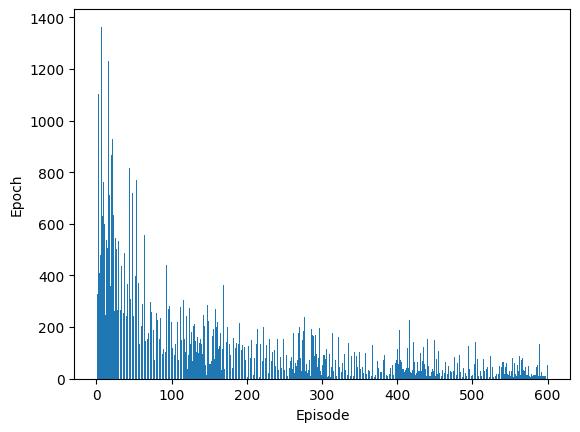

In [ ]:
import matplotlib.pyplot as plt 

num_episode = list(range(1, len(epochs_per_episode) + 1))
plt.bar(num_episode, epochs_per_episode)
plt.xlabel('Episode')
plt.ylabel('Epoch')
plt.show()

### Results 

This algorithm allowed our agent to learn online, which allowed it to achieve a terminal state much faster than the average-based MC methods in the first few episodes. Over time the value function converged enough to have multiple episodes that terminated in less than 50 time steps. Throughout the learning process, the policy being used was a stochastic epsilon greedy one to allow for exploration. Below, we examine the behavior of a deterministic policy against our learned value function. 

In [ ]:
state_start = env.reset()
i = 0
e = 0.01 #make policy less exploratory while testing 
env.reset()
env.render()
test_epochs_per_episode = []
for i in range(50): 
    test_epochs = 0 
    while not terminated: 
        test_epochs =+ 1 
        if type(state)==tuple: 
            state = state[0]
        
        #time.sleep(0.03)
        pi[state] = policy_fn(Q, action_space.n, e, state)
        action = np.random.choice(np.arange(action_space.n), p = pi[state])
        print(state)
        next_state, reward, terminated, truncated, step_dict = env.step(action)
        
        if terminated: 
            print(test_epochs)
            test_epochs_per_episode.append(test_epochs)
        state = next_state